# Apache Spark Lakehouse

## What is Apache Spark

A distributed data processing framework that enables large-scale data analytics by coorindating work across multiple processing nodes in a cluster. In Fabric this is a *Spark pool*.

Spark runs on Java, Scala, Spark R, Spark SQL, and PySpark.

Spark pool consists of compute *nodes* that distribute the data processing tasks. The nodes consist of:
1. A head node that coordinates distributed processes through a **driver** program.
2. Worker nodes which execute proceses the data.

*Example of general node architecture*

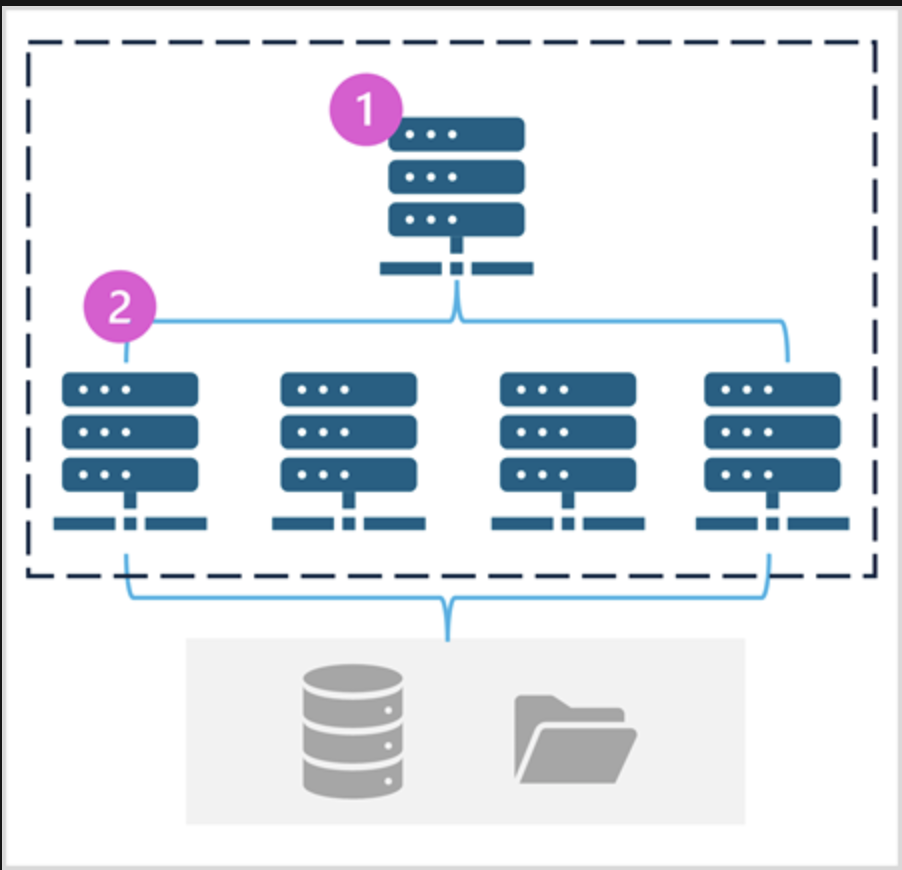



## Spark in Fabric

Each workspace is provided a *starter pool* for quick setup of Spark jobs. Customization or new spark pools can be setup for more complex or specific needs outside of the standard configuration. 
* Customized nodes may be disabled by Fabric administrator at the org level.

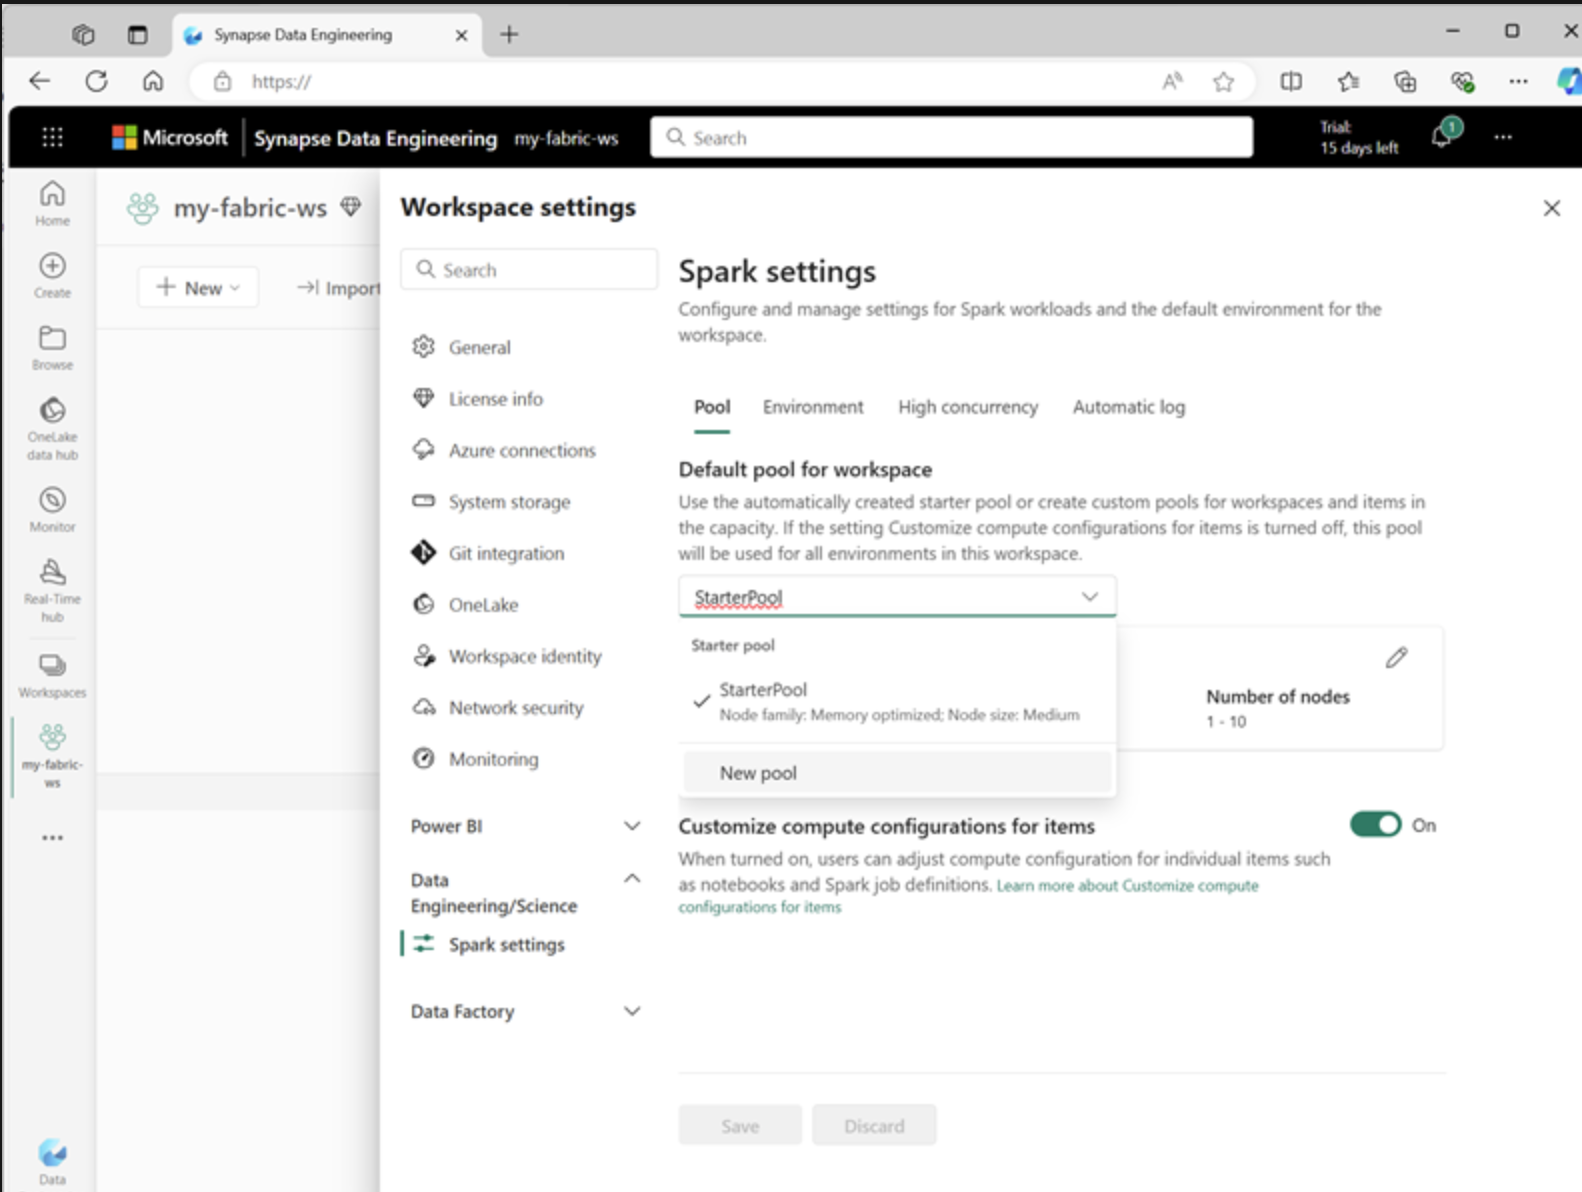

Custom settings: 
1. Node Family - type of virtual machines used for nodes. Memory optimized nodes provide optimate performance for general workloads
2. Autoscale - provision nodes as needed; Set the min and max nodes
3. Dynamic allocation - Whether or not to dynamically allocate executor processes on the worker nodes based on data volumes

## Spark Runtimes

Spark ecosystem includes multiple version of the Spark *runtime*. Determines the version of: 
1. Spark
2. Delta Lake
3. Python

Within the runtime options to install different libraries for general or specialized tasks are available. Organizations are free to setup multiple environments based on the runtime/libraries needed for the workload.

List of available runtimes are [here](https://learn.microsoft.com/en-us/fabric/data-engineering/runtime)

*Examples of Libraries Available in Fabric*

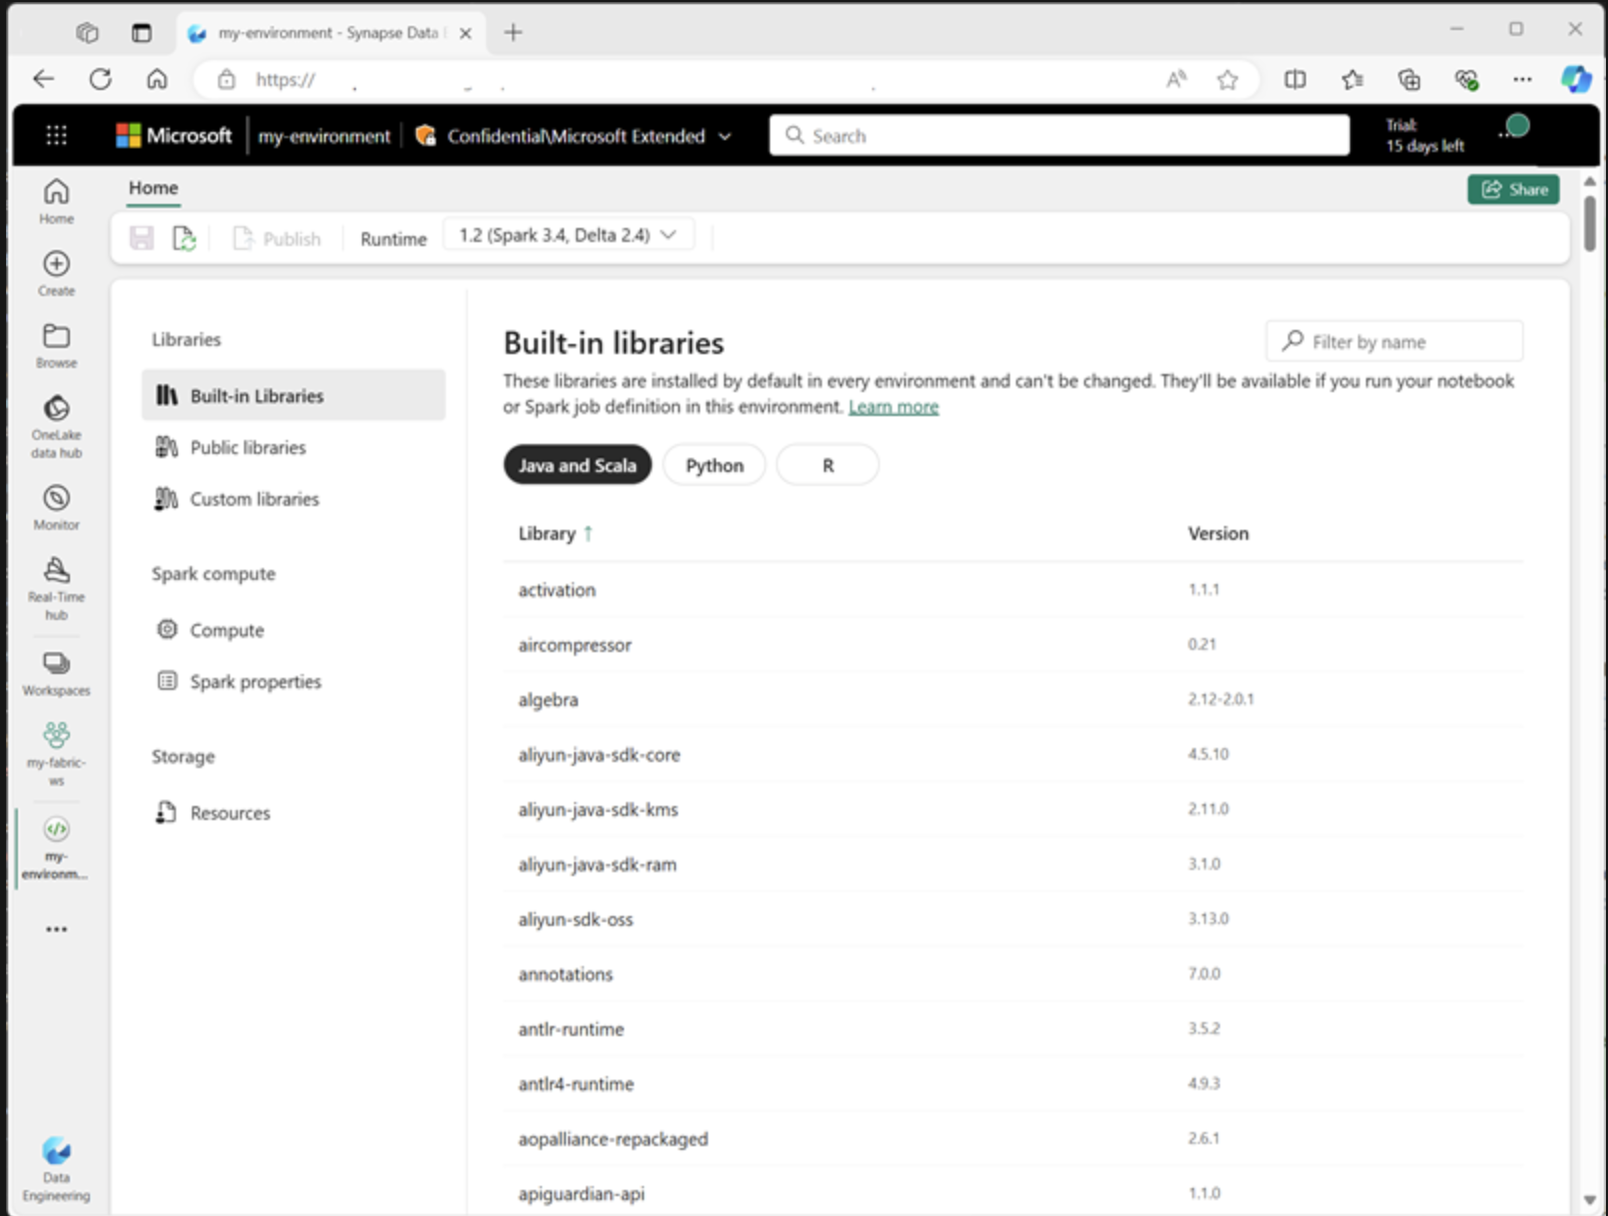

Options available when setting up environment:
1. Spark runtime
2. Built-in libraries installed on every environment
3. Install specific public libraries from PyPI
4. Install custom libraries through upload of package file
5. Specify Spark Pool for environment usage
6. Specify Spark configuration properties to override default behavior
7. Upload resoure files that need to be available in the environment

### Additional Spark Configuration Options

#### Native execution engine

Microsoft Fabric uses the *native execution engine* as the vectorized processing engine running Spark operations directly on the lakehouse infrastructure. This significantly improvates the perfoamcne of queries when working with large data sets in Parquet or Delta file formats.
* Parquet is a storage format optimized for efficiency but does not inherently support transactions or data versioning.
* Delta uses Parquet as its foundation but adds features like ACID transactions, versioning, and schema enforcement, making it more suitable for dynamic data processing and real-time analytics.

This can be configured to bypass the default settings at the environment configuration level or at a notebook context. 

Enabling native execution at the notebook level:

```
%%configure 
{ 
   "conf": {
       "spark.native.enabled": "true", 
       "spark.shuffle.manager": "org.apache.spark.shuffle.sort.ColumnarShuffleManager" 
   } 
}
```

#### High concurrency mode

Shares spark sessions across multiple concurrent users or processes. When enabled for notebooks, multiple users can run code in notebooks that use the same Spark session, while ensuring isolation of code to avoid variables in one notebook affecting another. 
This is available for Spark jobs for concurrent non-interactive Spark script execution.

Enabling high concurrency mode is available in the Data Engineering/Science section of the workspace settings interface.
* More details (here)[https://learn.microsoft.com/en-us/fabric/data-engineering/high-concurrency-overview]

#### Automatic MLFlow loggin

Open source library used in data science workloads to manage machine learning training and model deployment. Logs model training and management operations within the experiment activity section of the workspace without explicit code. This can be disabled if desired.


#### Spark administration for Fabric capacity

Administrators can manage Spark settings at the Fabric capacity level, allows restritions and override of Spark settings at the workspace level.


## Running Spark Code

### Notebooks

Allows for multiple languages and sharing of code between different members of the team. Each step of the process allows for data interaction.

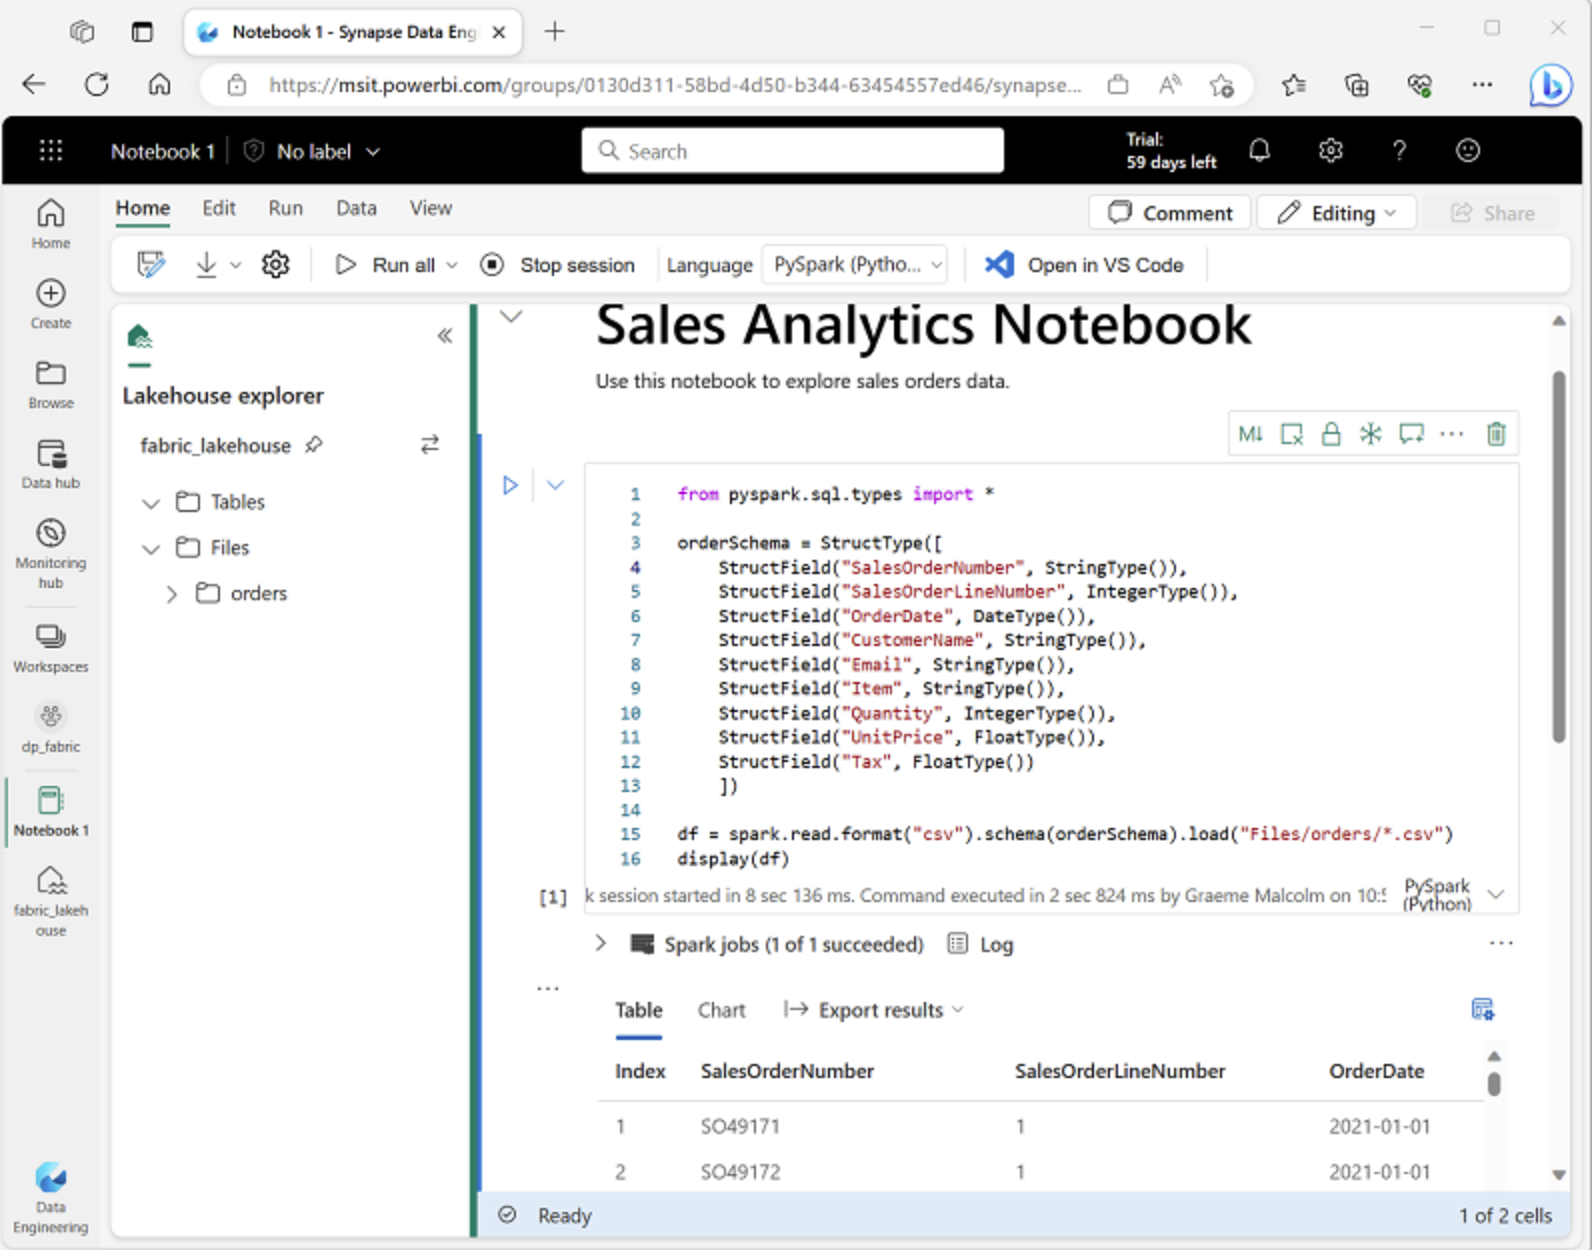


Pyspark is the default language of notebooks, however, Spark SQL, Scala, Java, and Spark R may be used. 
* This can be managed at the notebook level or using *magic commands* at the cell level

*Example of magic command changing to sql*
```
%%sql
SELECT YEAR(OrderDate) AS OrderYear,
       SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue
FROM salesorders
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;
```

Changing back to Pyspark is done by ```%%pyspark``` where Scala is ```%%spark```.
* Magic commands are case sensitive.

#### Visualize Data in Spark Notebooks

Notebooks provide basic charting visualizations when ran in a cell. View of the output can be manually converted to a chart view versus the data output. 

*Chart option under cell*

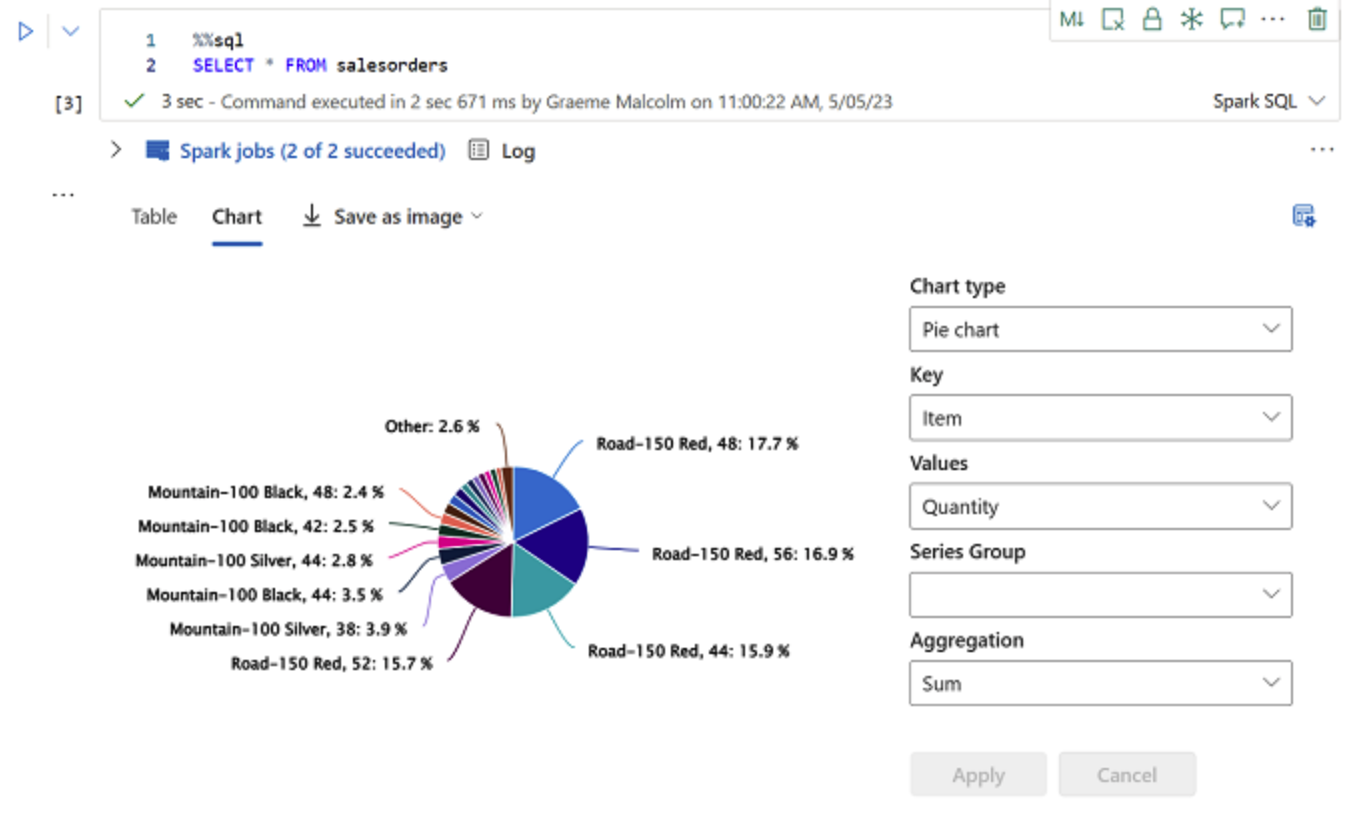


If more advanced visualation is needed for things such as EDA, standard python visual libraries may be used.
* Matplotlib, pyplot, seabonrn, etc





### Spark job definitions

Spark jobs are defined to ingest and transform data in an automated process, on-demand or scheduled. 

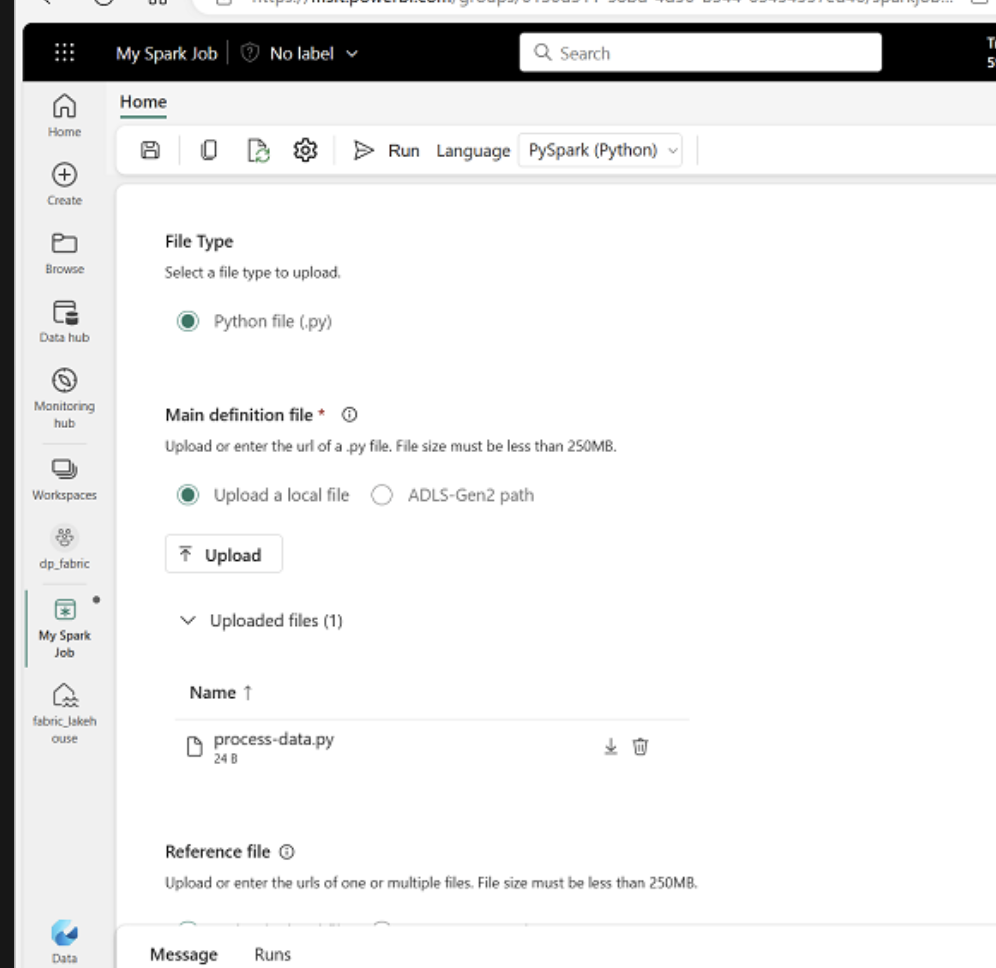


Jobs are setup without a workspace and may referance a predefined file with script information. Storage locations and specific cli arguments are used to define the context for jobs. 

### Scheduling notebook and job executiong

In production or more complex data ingestion solutions, notebooks and Spark jobs are added to the data pipeline for management. 

Notebooks are Spark jobs are ran within the security context of the logged in user. If using a schedule, it assumes the identity of the user who owns the pipeline.


## Data Sources for Spark

Notebooks are used to connect to data held in various data sources outside the workspace. Most common connections within Azure:
* Azure blob storage
* Azure SQL Database

### Azure Blob

Spark is used to ingest the data and transform before finally loading into a Lakehouse. 

*Example of loading a Lakehouse with a notebook*

```
# Azure Blob Storage access info
blob_account_name = "azureopendatastorage"
blob_container_name = "nyctlc"
blob_relative_path = "yellow"

# blob_sas_token = "add your SAS token here" 
# Construct the path for connection
wasbs_path = f'wasbs://{blob_container_name}@{blob_account_name}.blob.core.windows.net/{blob_relative_path}'

# WASBS path for connection including SAS token
# wasbs_path = f'wasbs://{blob_container_name}@{blob_account_name}.blob.core.windows.net/{blob_relative_path}?{blob_sas_token}'

# Read parquet data from Azure Blob Storage path
blob_df = spark.read.parquet(wasbs_path)

# Display the Azure Blob DataFrame
display(blob_df)
```


#### Alternate authentication

Alternative to legacy SAS tokens include **Service Principal** or **OAuth**.

*Example using Service Principal*

```
# Azure SQL Database connection info
server_name = "your_server_name.database.windows.net"
port_number = 1433  # Default port number for SQL Server
database_name = "your_database_name"
table_name = "YourTableName" # Database table

client_id = "YOUR_CLIENT_ID"  # Service principal client ID
client_secret = "YOUR_CLIENT_SECRET"  # Service principal client secret

# Build the Azure SQL Database JDBC URL with Service Principal 
jdbc_url = f"jdbc:sqlserver://{server_name}:{port_number};database={database_name};encrypt=true;trustServerCertificate=false;hostNameInCertificate=*.database.windows.net;loginTimeout=30;Authentication=ActiveDirectoryServicePrincipal"

# Properties for the JDBC connection 
properties = {
    "user": client_id,
    "password": client_secret
            }

# Read table from Azure SQL Database using Entra ID Service Principal
sql_df = spark.read.jdbc(url=jdbc_url, table=table_name, properties=properties)

# Display the Azure SQL dataframe
display (sql_df)
```

### Write Data into Lakehouse

After ingestion and transformation, the same notebook can write the dataframe into a lakehouse using relative paths. 

```
# Write dataframe to Parquet file format
parquet_output_path = "Files/your_folder/your_file_name"

df.write.mode("overwrite").parquet(parquet_output_path)

print(f"DataFrame has been written to Parquet file: {parquet_output_path}")
```

Data ingested through Spark can also be saved in other compatible formats
* JSON, Delta, CSV, Avro, ORC, etc.

#### Delta Table writes

Key feature of Fabric lakehouses because they support **ACID** transactions.
- Atomicity, consistency, isolation, durability.

*Dataframe saved to Delta table*

```
# Write dataframe to Delta table
delta_table_name = "your_delta_table_name"
df.write.format("delta").mode("overwrite").saveAsTable(delta_table_name)

# Confirm load as Delta table
print(f"DataFrame has been written to Delta table: {delta_table_name}")
```

When writing to Delta files, Fabric enables features by default to avoid the *small file problem*. Spark stores a large number of small problems due to the parallel-processing framekwork where data stored on multiple nodes. V-Order and Optimize write avoid this problem. 

**V-Order** enales faster and more efficient reads by special sorting, distribution, encoding, and compression on parquet files at write-time.

**Optimize write** improves performance and reliability by increasing file sizes. Useful for scenarios where Delta tables have suboptimal or nonstandard file sizes, or where the extra write latency is tolerable.


## Spark Dataframe

Natively Spark uses a data structure called **resilitient distributed dataset** or *RDD*. Code can be written for RDD but commonly Dataframes are used. 

Loading data into a dataframe (pyspark) allows schema inferance during load. this is the default behaviour for common data loads. 

*Example of inferance schema load*

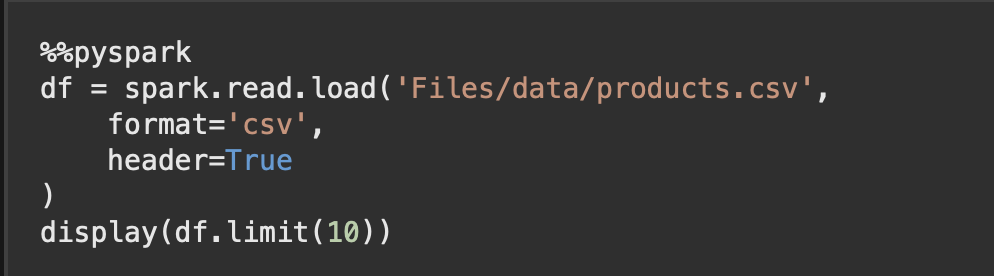


If a schema needs to be defined, during the dataframe load each column is configured with the appropriate data type. Even if specifying the schema is not required, it does improve performance over inferance.

*Manual schema definition in Spark*

```
from pyspark.sql.types import *
from pyspark.sql.functions import *

productSchema = StructType([
    StructField("ProductID", IntegerType()),
    StructField("ProductName", StringType()),
    StructField("Category", StringType()),
    StructField("ListPrice", FloatType())
    ])

df = spark.read.load('Files/data/product-data.csv',
    format='csv',
    schema=productSchema,
    header=False)
display(df.limit(10))
```


### Filtering and grouping dataframes


Dataframe functions for selecting data (like sql) are available

```dataframe.select("columnA","columnB")```

or the traditional Pandas style: ```dataframe["columnA","columnB"]```.

Data filtering can be chained to filer out and return the remaining dataframe information: 

```
bikes_df = df.select("ProductName", "Category", "ListPrice").where((df["Category"]=="Mountain Bikes") | (df["Category"]=="Road Bikes"))
display(bikes_df)

```

This results in a simple dataframe return: 

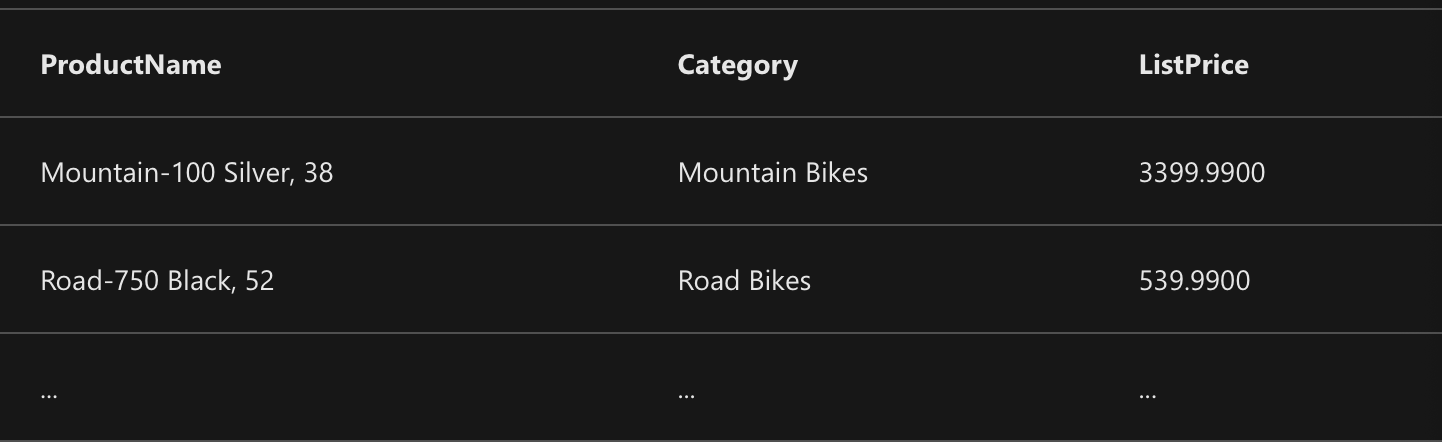


Grouping is available within the function ```dataframe.select("columnA","columnB").groupBy("ColumnB").count()```


## Spark SQL

### Tables and Spark catalog

The **Spark catalog** is a metastore for relational database objects such as views and tables. Allows SQL expressions to manipulate data for those that are more familiar/comfortable with SQL over Spark. Easiest way to accomplish this is to use a temporary view.

```df.createOrReplaceTempView("products_view")```

Views are temporary, automatically deleted at end of session. Tables can also be created that are persistant within the catalago to define a database for Spark SQL.
* Tables are metadata structures that store underlying data in the storage location associated with the catalog.

Microsoft Fabric data for **managed tables** are stored in the Tables storage location in a data lake, tables created by Spark are listed in this location.

*Creating a table in PySpark*

```
spark.catalog.createTable("sometable_name")

spark.catalog.saveAsTable("sometable_name")
```

When creating a table from a dataframe ```df.write.format("delta").saveAsTable("products")```.
* Spark supports saving different table filetypes but preferred is always delta in Fabric.

If a table needs to referance **external** data that is saved within a files saved location, ```spark.catalog.createExternalTable``` is used.
* For example, data in the Data Lake Files location


### Spark SQL API to Query Data

The DAtaframe API is park of the Spark library Spark SQL. This enables SQL expressions for analyst. 

*Example of SQL Query using API*

```
bikes_df = spark.sql("SELECT ProductID, ProductName, ListPrice \
                      FROM products \
                      WHERE Category IN ('Mountain Bikes', 'Road Bikes')")
display(bikes_df)
```

### Using SQL code in Notebook

This is referanced by the magic keyword ```%%sql``` at the beginning of the cell.

*Example of SQL Query in notebook*

```
%%sql

SELECT Category, COUNT(ProductID) AS ProductCount
FROM products
GROUP BY Category
ORDER BY Category
```



# Delta Lake Tables

Lake houses are built on the Linux Foundation *Delta Lake* table format commonly used in Apache Spark. Delta files are shown with a triangle icon on the file in workspaces/lakehouses.

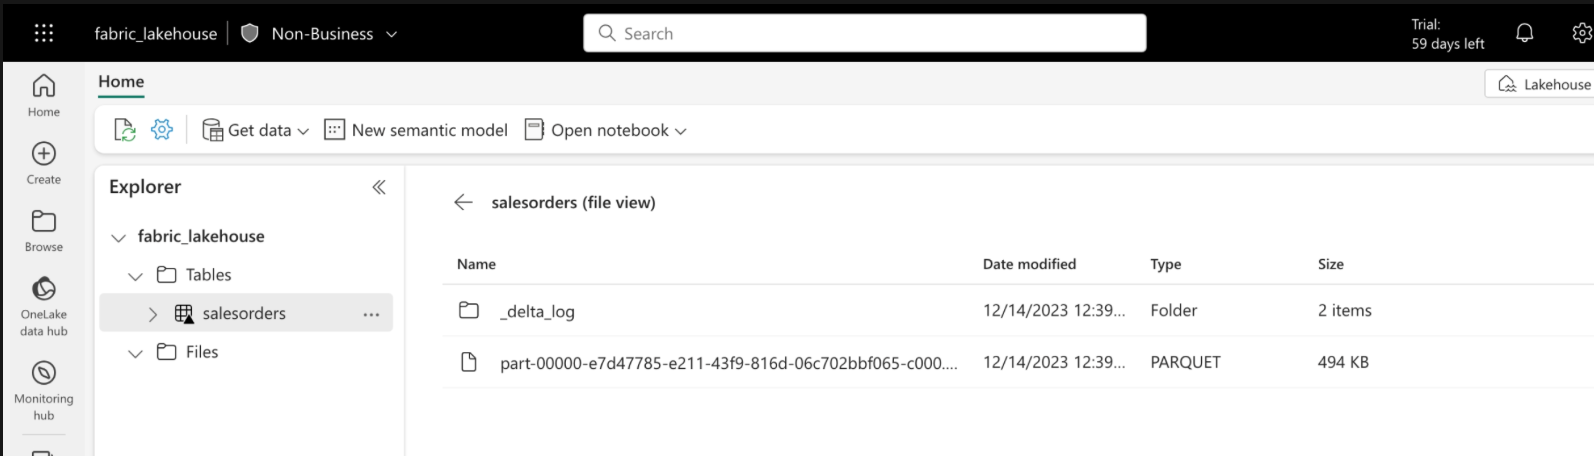

Delta tables are abstractions over data files that are stored in Delta format.
* Parquet files and delta_log folder is created; Log file is for transactions in JSON format.

**Benefits of Delta tables**

1. **Relation tables support querying and data modification** - Apache Spark allows standard CRUD changes to the data by inserting, updating, and deleting rows
2. **Support for ACID transactions** - Delta Lake brings this to Apache by implementing transaction logs and enforcing serializable isolation for concurrent operations.
3. **Data versioning and Time travel** - Tracking multiple versions of the table is available through the transaction log. Different versions of the same table row is available within the same query via the *time travel* feature.
4. **Support for batch and streaming data** - Spark natively supports streaming data through the **Spark Structured Streaming API**. Delta tables can be used as **sinks** (destinations) and sources for streaming.
5. **Standard formats and interoperability** - Parquet format is universally used, SQL endpoints for query access.


## Creating Delta Tables

The most common form of table creation is through a dataframe in a notebook. 

```
# Load a file into a dataframe
df = spark.read.load('Files/mydata.csv', format='csv', header=True)

# Save the dataframe as a delta table
df.write.format("delta").saveAsTable("mytable")
```

The table is saved within the given workspace lakehouse selected and the Tables section. The table structure is saved as parquet along with the standard formating and transaction logs.

### Managed vs External tables

**Managed tables** are saved and managed by the Spark runtime in a Lakehouse.
* table definition in the metastore and data files

**External tables** relational definitions in the metastore is mapped to an alternative file storage location. 

*Example of external table storage*

```
df.write.format("delta").saveAsTable("myexternaltable", path="Files/myexternaltable")
```

The example above will store the datafiles and log files within the external storage (files location) but the metastore will be shown within the Tables location in the lakehouse.

Fully Qualified Paths may be used as well:

```
df.write.format("delta").saveAsTable("myexternaltable", path="abfss://my_store_url..../myexternaltable")
```


Deleting the metastore of external tables **does not** delete the data files. 

### Creating Tabel metadata

Alternative to creating a table directly from a data frame. Useful for creating the Schema of a table and loading at a later time. This managed by the **DeltaTableBuilder API** that allows Spark code to create a table based on specifications. 

*Example of Delta Table creation*

```
from delta.tables import *

DeltaTable.create(spark) \
  .tableName("products") \
  .addColumn("Productid", "INT") \
  .addColumn("ProductName", "STRING") \
  .addColumn("Category", "STRING") \
  .addColumn("Price", "FLOAT") \
  .execute()

```


An alternative is using SparkSQL directly

```
%%sql

CREATE TABLE salesorders
(
    Orderid INT NOT NULL,
    OrderDate TIMESTAMP NOT NULL,
    CustomerName STRING,
    SalesTotal FLOAT NOT NULL
)
USING DELTA

```

External tables may be created using the **Location** keyword

```
%%sql

CREATE TABLE MyExternalTable
USING DELTA
LOCATION 'Files/mydata'
```

### Saving data in delta format

Creating data in delta format without the table metastore is useful when results of data transformation needs to persist in a Spark format but a table definition will be overlaid by using the delta lake in the future.

*Example saving a dataframe to folder in delta format*

```
delta_path = "Files/mydatatable"
df.write.format("delta").save(delta_path)
```

Delta files are saved in specified path and include a _delta_log folder containing transaction log files. 

Data can be overwritten the same way using pyspark dataframe
```new_df.write.format("delta").mode("overwrite").save(delta_path)```

Append mode allows addition of rows to the existing table structure

```new_rows_df.write.format("delta").mode("append").save(delta_path)```


### Create Delta Tables


Delta Lake removes the *small file problem* created by Parquet file format.
* Files are immutable and all future updates/deletes create new files
* Storing large number of small files causes queries to run slowly

*OptimizeWrite* is a feature of Delta Lake that writes fewer but larger files.
* Enabled by default in Fabric, can be disabled at the Spark session level
* Can be set in Table properties and for individual write commands

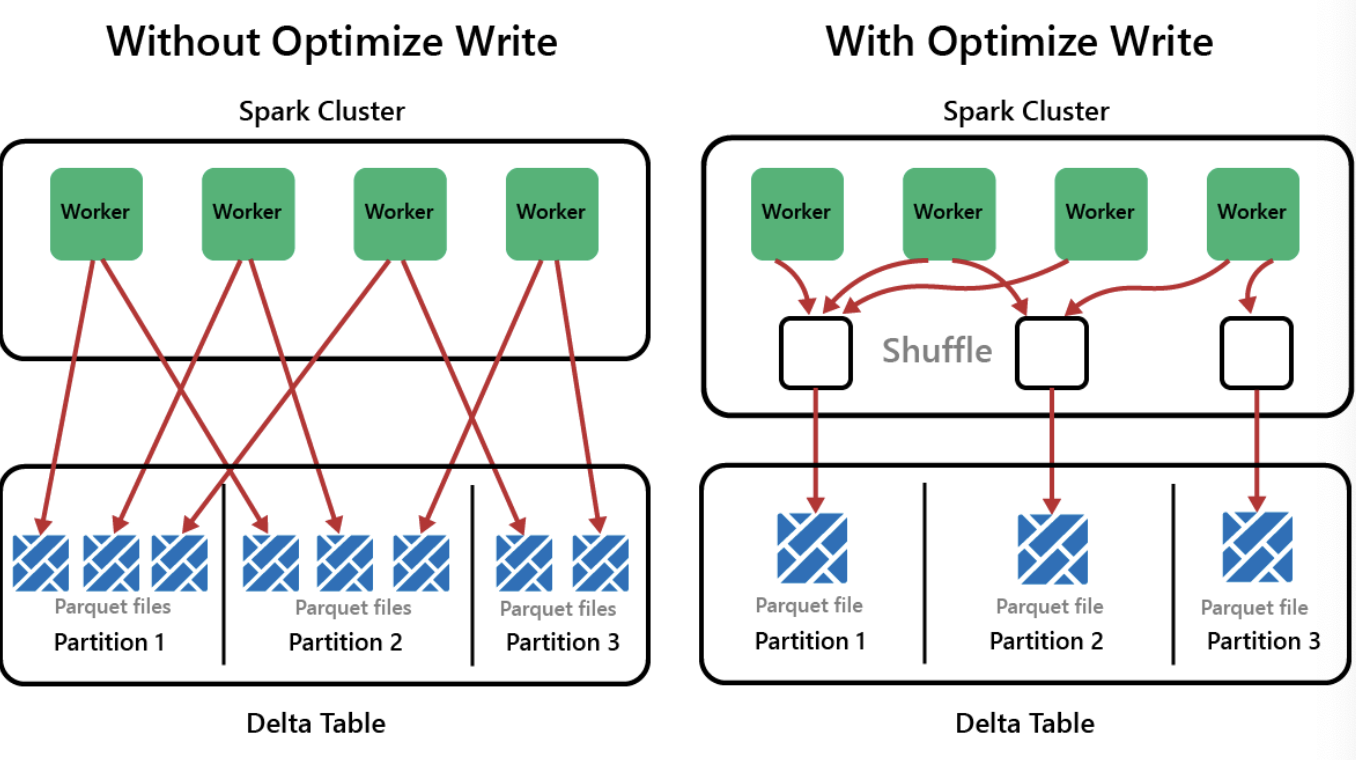



*Disabling OptimizeWrite Optional*

```
# Disable Optimize Write at the Spark session level
spark.conf.set("spark.microsoft.delta.optimizeWrite.enabled", False)

# Enable Optimize Write at the Spark session level
spark.conf.set("spark.microsoft.delta.optimizeWrite.enabled", True)

```

#### Optimize

A table maintenance feature that consolidates small parquet files into fewer large files. Ran after loading large tables.
* Fewer larger files
* better compression
* efficient data distribution across Spark nodes

To run:
1. Lakehouse Explorer menu -> **Maintenance**
2. Select **RUN OPTIMIZE**
3. Optionally select *Apply V-order* to maximize reading speeds
4. Select *Run now*

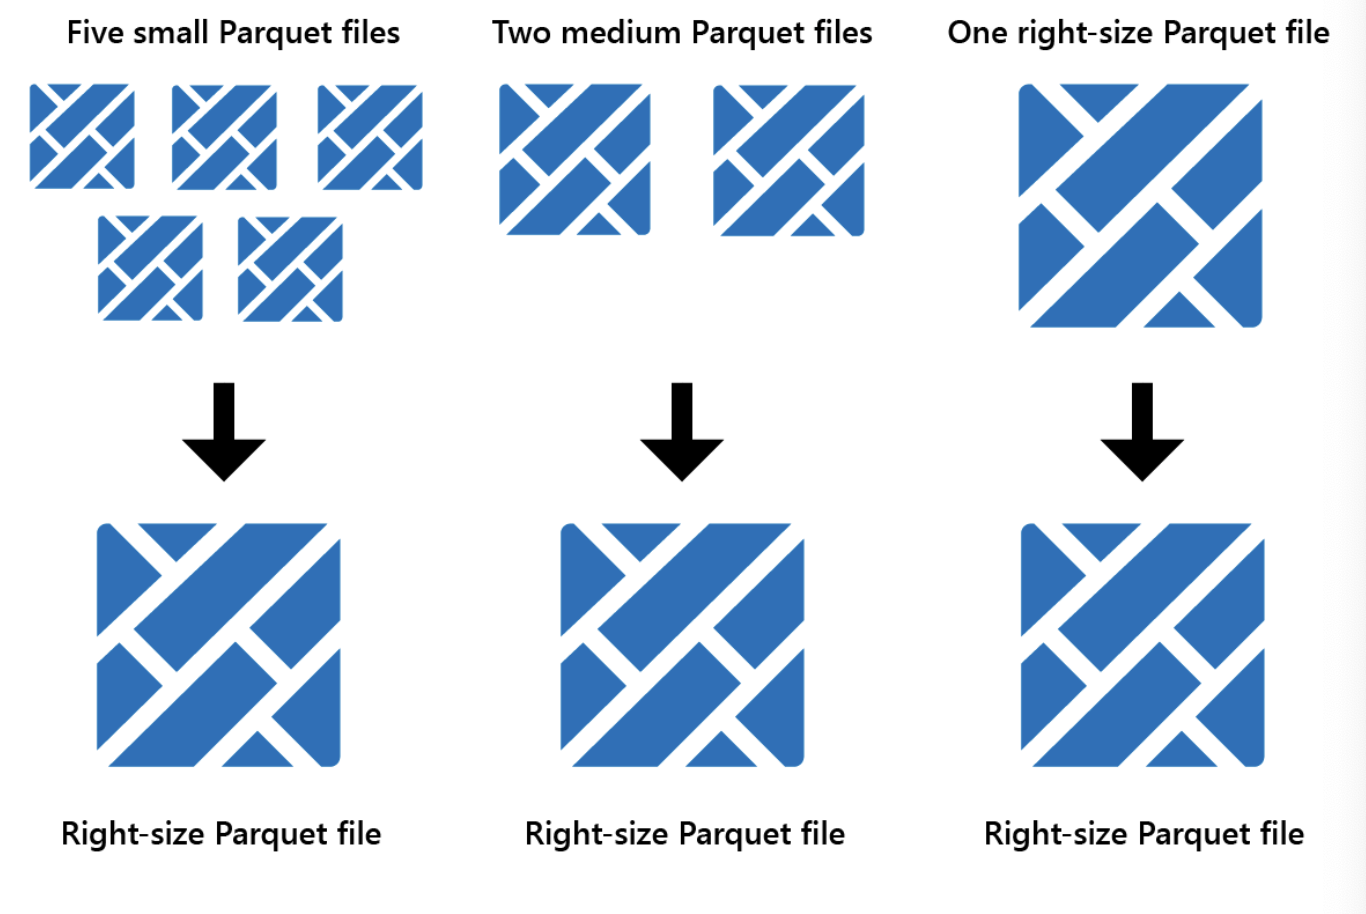



#### V-Order Function

Designed for the Parquet file format in Fabric. Enables fast reads with in-memory-like data access times. Reduces netowrk, disk, and CPU costs.
* Enabled by default in Fabric
* Small overhead increasing write speed time by ~15%

Features that use V-Order:
1. Power BI and SQL - full benefit using Microsoft Verti-Scan.
2. Spark and other engines - Atleast 10% faster reads and some cases up to 50%

V-order usually not beneficial for write-intesive scenarioes such as staging, areas where data is read once or twice. Disable V-Order might here for reduced data ingestion time. 

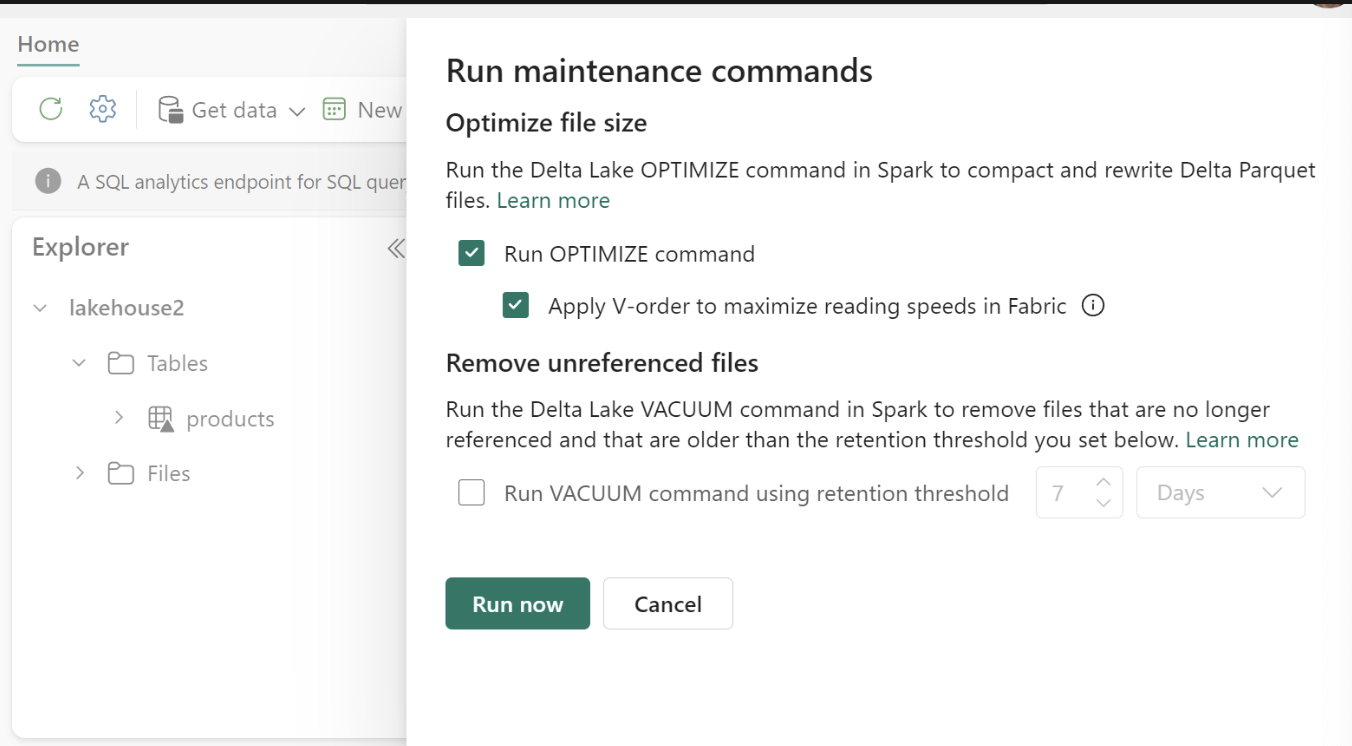


#### Vacuum

Enables the removal of old data files. Running the **Vacuum** command removes the ability to use time travel on the data.
* Data files are deleted but transaction logs are left behind
* Vacuum is not ran by default for time travel benefit

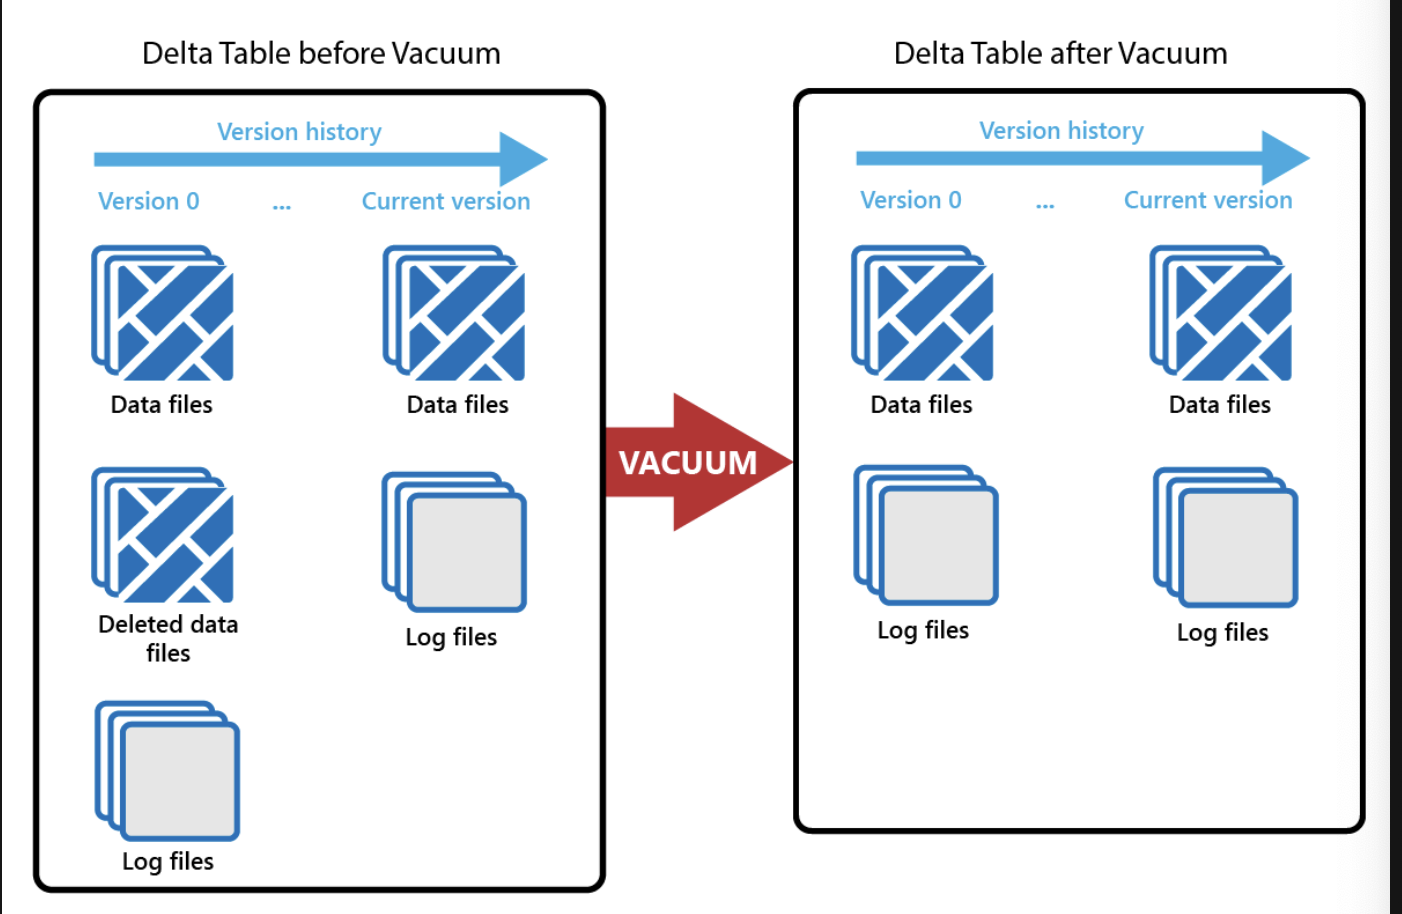

Data files that are not currently referenced in a transaction log and that are older than the specified retention period are permanently deleted.

Selecting a retention period: 
* Data retention requirements
* Data size and storage costs
* Data change frequency
* Regulatory requirements

Default retention period is 7 days (168 hours) and the system prevents using a shorter period.


Running Vacuum can be ad-hoc or on a Maintenance schedule. 

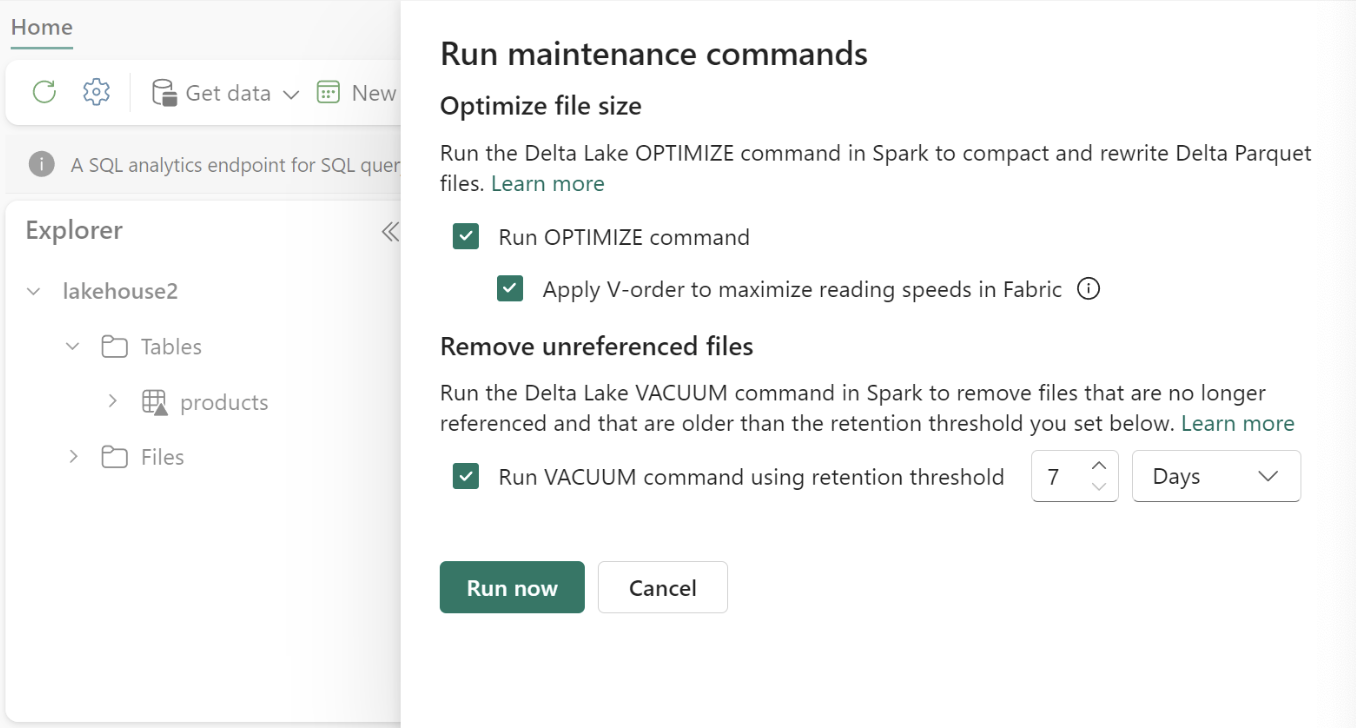


**Vacuum in a Notebook**
Using the magic command for sql, notebooks may run Vacuum.

```
%%sql
VACUUM lakehouse2.products RETAIN 168 HOURS
```


### Partitioning Delta tables

